In [50]:
import os
import torch
from torch import nn
from torchvision.models import resnet50
from torch import optim
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset, RandomSampler
from torchvision import transforms, utils
from typing import List, Tuple
from PIL import Image

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


In [171]:
# Convert CSV to DataLoader
# Followed tutorial: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

# Let's start by creating the forgetting set. This will require merging our genre and artist data together.
artist_data = pd.read_csv("wikiart_csv/artist_train.csv")
artist_data.columns = ["file", "artist"]
genre_data = pd.read_csv("wikiart_csv/genre_train.csv")
genre_data.columns = ["file", "genre"]
data = pd.merge(artist_data, genre_data, on="file", how="inner")

# In this case, we will be trying to forget the artist Salvador Dali or class 21
forget_data = data[data['artist'] == 21]
retain_data = data[data['artist'] != 21]

# Create the validation/test sets
genre_test = pd.read_csv("wikiart_csv/genre_val.csv")
genre_test.columns = ["file", "genre"]

In [222]:
class ArtDataset(Dataset):
    train_file = "genre_train.csv"
    test_file = "genre_val.csv"
    class_labels = {
        "abstract_painting" : 0, 
        "cityscape" : 1, 
        "genre_painting" : 2,
        "illustration" : 3,
        "landscape" : 4,
        "nude_painting" : 5,
        "portrait" : 6,
        "religious_painting" : 7,
        "sketch_and_study" : 8,
        "still_life" : 9
    }

    def __init__(self, root, data, transform: transforms.Compose = None):
        self.root = root
        self.transform = transform
        self.class_dict = self.class_labels
        self.dataset = data[["file", "genre"]]

    def art_from_path(self, path: str) -> Image:
        if os.path.exists(path):
            try:
                img = Image.open(path)
                img.load()
                return img
            except (IOError, OSError) as e:
                print("ERROR", path)
                return None
        else:
            return None

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img_path = self.dataset.iloc[index, 0]
        class_idx = self.dataset.iloc[index, 1]
        img = self.art_from_path(os.path.join(self.root,"wikiart", img_path))
        if img is None:
            return(self.__getitem__((index + 1) % len(self)))
        if self.transform:
            img = self.transform(img)
        return img, class_idx

    def __len__(self) -> int:
        return len(self.dataset)

In [223]:
# Some of the setup was adapted from starter code in 

def train_transforms(size: Tuple[int, int]) -> transforms.Compose:
    return transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.Resize(size),
        transforms.ToTensor()
    ])

def test_transforms(size: Tuple[int, int]) -> transforms.Compose:
    return transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor()
    ])
size = (224, 224)

forget_dataset = ArtDataset('/Users/julieyoung/Documents/a-Spring-2025/DL/Project', forget_data, train_transforms(size))
forget_loader = torch.utils.data.DataLoader(forget_dataset, batch_size=128, shuffle=True)

retain_dataset = ArtDataset('/Users/julieyoung/Documents/a-Spring-2025/DL/Project', retain_data, train_transforms(size))
retain_loader = torch.utils.data.DataLoader(retain_dataset, batch_size=128, shuffle=True)

genre_held_out = ArtDataset('/Users/julieyoung/Documents/a-Spring-2025/DL/Project', genre_test, test_transforms(size))
test_set, val_set = torch.utils.data.random_split(genre_held_out, [0.5, 0.5])
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=True)

In [174]:
# This function was adapted from starter code in Machine Unlearning competition: https://github.com/unlearning-challenge/starting-kit

# INPUT:
# model - model being unlearned
# inputs - input data (Batch_Size, img_shape)
# targets - actual labels (Batch_Size, )
# mia - (boolean) -> whether the data is training the mia or the unlearner

# OUTPUT:
# Losses - (Batch_size, number of classes + 1)

def generate_data(inputs, targets, net, mia):
    criterion = nn.CrossEntropyLoss(reduction="none")

    logits = net(inputs)
    if mia:
      logits = logits.detach()
    losses = criterion(logits, targets).unsqueeze(1)

    logit_loss = torch.cat((losses, logits), dim=1)

    return logit_loss

In [175]:
# Generate data used to train MIA model
# This function was adapted from starter code in Machine Unlearning competition: https://github.com/unlearning-challenge/starting-kit

# Params:
# model - model being unlearned
# loader - DataLoader to calculate MIA data over
# mia - (boolean) -> whether the data is training the mia or the unlearner

# Out:
# mia_data - (Batch_size, number of classes + 1) -> concat(CrossEntropyLoss, model logits)

def generate_data_from_loader(model, loader, mia):
    all_data = None
    for data, labels in loader:
      data, labels = data.to(DEVICE), labels.to(DEVICE)

      logit_loss = generate_data(data, labels, model, mia)

      if (all_data is None):
        all_data = logit_loss
      else:
        all_data = torch.concat((all_data, logit_loss))

    return all_data

In [267]:
# Calculate accuracy of MIA given logits and train/test label
def mia_accuracy(logits, labels):
  logits = torch.sigmoid(logits)
  pred = torch.where(logits >= 0.5, 1, 0).squeeze()
  diff = torch.abs(pred - labels)
  correct = len(logits) - torch.sum(diff)
  return(correct / len(labels))

# Function to validate the MIA
# Params:
# model - MIA model
# loader - dataset loader containing validation data
def validate_mlp(model, loader):
  total = 0
  correct = 0
  for data, labels in loader:
    data = data.to(DEVICE)
    labels = labels.to(DEVICE)

    logits = model(data)
    logits = torch.sigmoid(logits)
    pred = torch.where(logits >= 0.5, 1, 0).squeeze()

    total += len(pred)
    diff = pred - labels
    correct += (len(pred) - torch.count_nonzero(diff))

  return (correct / total)

# Calculate accuracy of unlearning model
def unlearner_acc(model, loader):
  total = 0
  correct = 0
  for data, labels in loader:
    data = data.to(DEVICE)
    labels = labels.to(DEVICE)

    logits = model(data)
    pred = torch.max(logits, dim=1)[1]

    total += len(pred)
    diff = pred - labels
    correct += (len(pred) - torch.count_nonzero(diff))

  return (correct / total)

In [177]:
# Define Art Resnet Model
class ArtResnet(nn.Module):
    def __init__(self):
        super().__init__()
        model = resnet50(pretrained = True)
        layers = list(model.children())
        self.conv_layers = nn.Sequential(
            layers[0],
            layers[1],
            layers[2],
            layers[3],
            layers[4],
            layers[5],
            layers[6],
        )

        for p in self.conv_layers.parameters():
            p.requires_grad = False

        self.fc_layers = nn.Sequential(
            layers[7],
            layers[8],
            nn.Flatten(),
            nn.Linear(in_features = 2048, out_features = 10, bias = True)
        )
        
        self.loss_criterion = nn.CrossEntropyLoss(reduction = 'mean')

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        model_output = self.conv_layers(x)
        model_output = self.fc_layers(model_output)
        return model_output

In [178]:
# Load the trained model
checkpoint = torch.load('art-classifier-weights.pt')
my_resnet = ArtResnet()
my_resnet.load_state_dict(checkpoint['model_state_dict'])

/Users/julieyoung/anaconda3/envs/ml_hw3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/julieyoung/anaconda3/envs/ml_hw3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
# Find prior accuracy on retain dataset, forget dataset, and test dataset
print(unlearner_acc(my_resnet, retain_loader))
print(unlearner_acc(my_resnet, forget_loader))
print(unlearner_acc(my_resnet, test_loader))


tensor(0.7737)


In [260]:
# Build dataset for pre-training MIA model
# Build DataLoader for training the MLP model
pos_weight = len(val_loader.dataset)/len(forget_loader.dataset)
train_losses = generate_data_from_loader(my_resnet, forget_loader, True)

val_losses = generate_data_from_loader(my_resnet, val_loader, True)

print("Train losses shape: ", train_losses.shape)
print("Test losses shape: ", val_losses.shape)

# Make the full training dataset by concatenating the loss associated with training samples and test samples
training_data = torch.concat((train_losses, val_losses))
training_labels = torch.concat((torch.ones(train_losses.shape[0]), torch.zeros(val_losses.shape[0])))
idx = torch.randperm(training_data.shape[0])
training_data = training_data[idx]
training_labels = training_labels[idx]
print(training_data.shape)

# Separate dataset into train and test sets
idx = (int) (0.8 * len(training_data))
mlp_train_data = training_data[0:idx]
mlp_test_data = training_data[idx:]
mlp_train_labels = training_labels[0:idx]
mlp_test_labels = training_labels[idx:]

# Build train and test datasets and dataloaders
mlp_train_dataset = torch.utils.data.TensorDataset(mlp_train_data.cpu(), mlp_train_labels.cpu())
mlp_test_dataset = torch.utils.data.TensorDataset(mlp_test_data.cpu(), mlp_test_labels.cpu())

mlp_train_loader = torch.utils.data.DataLoader(
    mlp_train_dataset, batch_size=128, shuffle=True
)
mlp_test_loader = torch.utils.data.DataLoader(
    mlp_test_dataset, batch_size=128, shuffle=True
)

Train losses shape:  torch.Size([266, 11])
Test losses shape:  torch.Size([9745, 11])
torch.Size([10011, 11])


In [ ]:
# Training the MLP conducting MIAs

def train_mia(model, optimizer, loader, epochs, criterion):
  loss_list = []
  acc_list = []
  val_list = []
  for idx in range(epochs):
    model.train()
    batch_loss = 0
    count = 0
    for data, labels in loader:
      data = data.to(DEVICE)
      labels = labels.to(DEVICE)
      count += 1
      optimizer.zero_grad()
      out = model(data)
      loss = criterion(out, labels.unsqueeze(1))
      loss.backward()
      optimizer.step()
      batch_loss += loss.item()
    if ((idx % 5) == 0):
      print("EPOCH " + str(idx) + " Loss: " + str(batch_loss/count))
      loss_list.append(batch_loss/count)
      mia_acc = mia_accuracy(out, labels)
      print("ACCURACY: ", mia_acc)
      acc_list.append(mia_acc)
      model.eval()
      val_acc = validate_mlp(model, mlp_test_loader)
      print("VALIDATION: ", val_acc)
      val_list.append(val_acc)
      
  return (loss_list, acc_list, val_list)

In [262]:
# Define MIA model architecture
class MiaModel(nn.Module):

  def __init__(self, input_size, hidden_size):
    super(MiaModel, self).__init__()

    self.linear1 = nn.Linear(input_size, hidden_size[0])
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(hidden_size[0], hidden_size[1])
    self.fc = nn.Linear(hidden_size[1], 1)
    self.dropout = nn.Dropout(p=0.3)
    self.batchnorm1 = nn.BatchNorm1d(hidden_size[0])

  def forward(self, x):
    x = self.linear1(x)
    x = self.batchnorm1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.linear2(x)
    x = self.relu(x)
    x = self.fc(x)
    return(x)

In [ ]:
# Begin pre-training
mia_model = MiaModel(11, (30, 25)).to(DEVICE)

# RUN TO RETRAIN
pretrain_optim = torch.optim.Adam(mia_model.parameters(), lr=1e-5, weight_decay=1e-4)
crit = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))
# crit = nn.BCEWithLogitsLoss()
loss_list, acc_list, val_list = train_mia(mia_model, pretrain_optim, mlp_train_loader, 60, crit)
print(loss_list)
print(acc_list)

torch.save(mia_model.state_dict(), './mia_model_weights.pth')

# RUN TO RELOAD WEIGHTS
# mia_model.load_state_dict(torch.load('model_weights.pth'))

EPOCH 0 Loss: 1.35366614091964
ACCURACY:  tensor(0.1944)
VALIDATION:  tensor(0.1563)
EPOCH 5 Loss: 1.349404553572337
ACCURACY:  tensor(0.1667)
VALIDATION:  tensor(0.1618)
EPOCH 10 Loss: 1.3470513726037645
ACCURACY:  tensor(0.1528)
VALIDATION:  tensor(0.1697)
EPOCH 15 Loss: 1.345465892837161
ACCURACY:  tensor(0.1944)
VALIDATION:  tensor(0.1772)
EPOCH 20 Loss: 1.3441872502130174
ACCURACY:  tensor(0.2639)
VALIDATION:  tensor(0.1867)
EPOCH 25 Loss: 1.3397318701895455
ACCURACY:  tensor(0.2222)
VALIDATION:  tensor(0.1922)
EPOCH 30 Loss: 1.3410997807033478
ACCURACY:  tensor(0.2917)
VALIDATION:  tensor(0.2067)
EPOCH 35 Loss: 1.336982203854455
ACCURACY:  tensor(0.2917)
VALIDATION:  tensor(0.2067)
EPOCH 40 Loss: 1.3330804582626101
ACCURACY:  tensor(0.2222)
VALIDATION:  tensor(0.2077)
EPOCH 45 Loss: 1.338471007725549
ACCURACY:  tensor(0.2500)
VALIDATION:  tensor(0.2277)
EPOCH 50 Loss: 1.3284622421340337
ACCURACY:  tensor(0.3611)
VALIDATION:  tensor(0.2302)
EPOCH 55 Loss: 1.3312010292022947
ACCURA

In [ ]:
%pip install matplotlib

290139.37s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.


Text(0, 0.5, 'MIA Accuracy')

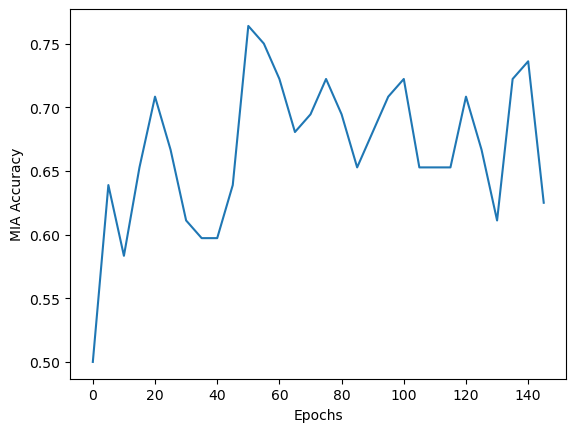

In [196]:
import matplotlib.pyplot as plt


x = np.arange(0, 150, 5)
y = acc_list

plt.plot(x, y)
plt.xlabel("Epochs")
plt.ylabel("MIA Accuracy")


In [ ]:
import matplotlib.pyplot as plt

x = np.arange(0, 150, 5)
y = loss_list

plt.plot(x, y)
plt.xlabel("Epochs")
plt.ylabel("MIA Loss")

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(0, 130, 5)
y1 = acc_list
y2 = val_list

plt.plot(x, y1, label="training")
plt.plot(x, y2, label="validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
# This function was adapted from starter code in Machine Unlearning competition: https://github.com/unlearning-challenge/starting-kit
def unlearning(net, mia_model, retain, forget, validation):

    epochs = 20

    # Set criterion and optimizers
    model_crit = nn.CrossEntropyLoss()
    mia_crit = nn.BCEWithLogitsLoss()
    model_optim = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-4)
    mia_optim = torch.optim.Adam(mia_model.parameters(), lr=3e-3, weight_decay=1e-4)

    mia_accuracy = []
    retain_acc = []
    forget_acc = []

    for i in range(epochs):

        # Start by computing the loss with the retain set and updating the unlearning model accordingly
        net.train()
        for inputs, targets in retain:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            model_optim.zero_grad()
            outputs = net(inputs)
            loss = model_crit(outputs, targets)
            loss.backward()
            model_optim.step()

        # Run through each batch in the forgetting set
        for data, labels in forget:

          data = data.to(DEVICE)
          labels = labels.to(DEVICE)

          # Create Auditor Subset
          # Randomly sample from the validation set to update the MIA
          idx = torch.randperm(len(validation.dataset))
          rand_idx = idx[:len(labels)]
          valid_subset = Subset(validation.dataset, rand_idx)
          valid_subset_loader = DataLoader(valid_subset, batch_size=128, shuffle=True)

          # Generate data for MIA model
          # The logits generated by the forgetting model should be detached to prevent gradient flow
          forget_mia_data = generate_data(data, labels, net, True)
          for valid_data, valid_label in valid_subset_loader:
            valid_data, valid_label = valid_data.to(DEVICE), valid_label.to(DEVICE)
            valid_mia_data = generate_data(valid_data, valid_label, net, True)

          # Combine data, create labels, and randomize
          mia_train_data = torch.concat((forget_mia_data, valid_mia_data))
          mia_train_labels = torch.concat((torch.ones(len(forget_mia_data)), torch.zeros(len(valid_mia_data))))
          rand_idx = torch.randperm(len(mia_train_labels))
          mia_train_data = mia_train_data[rand_idx]
          mia_train_labels = mia_train_labels[rand_idx]

          print("UPDATE MIA")
          # Update MIA model
          net.eval()
          mia_model.train()
          mia_optim.zero_grad()
          mia_logits = mia_model(mia_train_data)
          loss = mia_crit(mia_logits.squeeze().to(DEVICE), mia_train_labels.to(DEVICE))
          loss.backward()
          mia_optim.step()

          # Generate data for training the forgetting model
          # The logits generated by the forgetting model should NOT be detached because the gradients should flow all the way backwards
          forget_net_data = generate_data(data, labels, net, False)
          for valid_data, valid_label in valid_subset_loader:
            valid_data, valid_label = valid_data.to(DEVICE), valid_label.to(DEVICE)
            valid_net_data = generate_data(valid_data, valid_label, net, False)

          # Combine data, create labels, and randomize
          net_train_data = torch.concat((forget_net_data, valid_net_data))
          # IMPORTANT: The zeros and ones should be flipped from the expected values as the unlearning model is trying to fool the MIA
          net_train_labels = torch.concat((torch.zeros(len(forget_net_data)), torch.ones(len(valid_net_data))))
          rand_idx = torch.randperm(len(net_train_labels))
          net_train_data = net_train_data[rand_idx]
          net_train_labels = net_train_labels[rand_idx]

          print("UPDATE UNLEARNER")
          # Update the unlearning model
          mia_model.eval()
          net.train()
          model_optim.zero_grad()
          mia_logits = mia_model(net_train_data)
          loss = mia_crit(mia_logits.squeeze().to(DEVICE), net_train_labels.to(DEVICE))
          loss.backward()
          model_optim.step()

        if ((i % 2) == 0):
          print("IDX", i)
          # Calculate net accuracy on retain subset
          net.eval()
          correct = 0
          total = 0
          sampler = RandomSampler(retain, replacement=False, num_samples=1000)
          # Code for accuracy was taken from Machine Unlearning Kaggle competition starter code: https://github.com/unlearning-challenge/starting-kit
          for inputs, targets in DataLoader(retain.dataset, batch_size=128, sampler=sampler):
              inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
              outputs = net(inputs)
              _, predicted = outputs.max(1)
              total += targets.size(0)
              correct += predicted.eq(targets).sum().item()
          print("NET ACCURACY ON RETAIN: ", correct / total)
          retain_acc.append((correct/total))

          # Calculate accuracy on forget subset
          net.eval()
          correct = 0
          total = 0
          sampler = RandomSampler(forget, replacement=False, num_samples=1000)
          # Code for accuracy was taken from Machine Unlearning Kaggle competition starter code: https://github.com/unlearning-challenge/starting-kit
          for inputs, targets in DataLoader(forget.dataset, batch_size=128, sampler=sampler):
              inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
              outputs = net(inputs)
              _, predicted = outputs.max(1)
              total += targets.size(0)
              correct += predicted.eq(targets).sum().item()
          print("NET ACCURACY ON FORGET: ", correct / total)
          forget_acc.append((correct/total))

          # Calculate MIA accuracy
          mia_model.eval()
          mia_acc = validate_mlp(mia_model, mlp_test_loader)
          print("MIA ACCURACY: ", mia_acc)
          mia_accuracy.append(mia_acc.item())


    net.eval()
    return net, mia_accuracy, retain_acc, forget_acc

In [ ]:
ft_model, mia_accuracy, retain_acc, forget_acc = unlearning(my_resnet, mia_model, retain_loader, forget_loader, val_loader)
torch.save(ft_model.state_dict(), './ft_model_weights.pth')

UPDATE MIA
UPDATE UNLEARNER
UPDATE MIA
UPDATE UNLEARNER
UPDATE MIA
UPDATE UNLEARNER
IDX 0
NET ACCURACY ON RETAIN:  0.837
NET ACCURACY ON FORGET:  0.667
MIA ACCURACY:  tensor(0.5157)
UPDATE MIA
UPDATE UNLEARNER
UPDATE MIA
UPDATE UNLEARNER
UPDATE MIA
UPDATE UNLEARNER
UPDATE MIA
UPDATE UNLEARNER
UPDATE MIA
UPDATE UNLEARNER
UPDATE MIA
UPDATE UNLEARNER
IDX 2
NET ACCURACY ON RETAIN:  0.838
NET ACCURACY ON FORGET:  0.666
MIA ACCURACY:  tensor(0.5976)
UPDATE MIA
UPDATE UNLEARNER
UPDATE MIA
UPDATE UNLEARNER
UPDATE MIA
UPDATE UNLEARNER
UPDATE MIA
UPDATE UNLEARNER
UPDATE MIA
UPDATE UNLEARNER
UPDATE MIA
UPDATE UNLEARNER
IDX 4
NET ACCURACY ON RETAIN:  0.867
NET ACCURACY ON FORGET:  0.823
MIA ACCURACY:  tensor(0.5671)
UPDATE MIA
UPDATE UNLEARNER
UPDATE MIA
UPDATE UNLEARNER
UPDATE MIA
UPDATE UNLEARNER
UPDATE MIA
UPDATE UNLEARNER
UPDATE MIA
UPDATE UNLEARNER
UPDATE MIA
UPDATE UNLEARNER
IDX 6
NET ACCURACY ON RETAIN:  0.896
NET ACCURACY ON FORGET:  0.834
MIA ACCURACY:  tensor(0.4963)
UPDATE MIA
UPDATE UN

KeyboardInterrupt: 

In [ ]:
# Find end accuracies
# Find prior accuracy on retain dataset, forget dataset, and test dataset
print(unlearner_acc(ft_model, retain_loader))
print(unlearner_acc(ft_model, forget_loader))
print(unlearner_acc(ft_model, test_loader))


In [ ]:
import matplotlib.pyplot as plt
x = np.arange(0, 30, 2)
y1 = np.array(mia_accuracy)
y2 = np.array(retain_acc)
y3 = np.array(forget_acc)

plt.plot(x, y1, label="MIA accuracy")
plt.plot(x, y2, label="retain accuracy")
plt.plot(x, y3, label="forget accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()